In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import torch.utils.data

# !pip install d2l==1.0.3

# Logistic Regression on MNIST

In [2]:
from torchvision.datasets import MNIST

mnist_train = MNIST(root=".",      # where on the disk to store the data
                    download=True, # download the data if it does not already exist
                    train=True)    # use the training set (rather than the test set)

100%|██████████| 9912422/9912422 [00:00<00:00, 108161638.06it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 108447353.47it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 33905915.96it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 9916985.30it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [3]:
print(mnist_train[0]) # a tuple consisting of the image, and the label (5)

(<PIL.Image.Image image mode=L size=28x28 at 0x79E2148FC4C0>, 5)


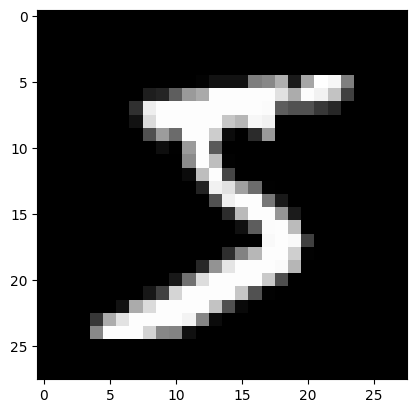

In [4]:
plt.imshow(mnist_train[0][0], cmap='gray') # display the image

In [5]:
import torchvision.transforms as transforms

mnist_data = MNIST(root=".",      # where on the disk to store the data
                   download=True, # download the data if it does not already exist
                   train=True,    # use the canonical training set (rather than the test set)
                   transform=transforms.ToTensor()) # transforms the images into PyTorch tensors
mnist_data = list(mnist_data)#[:5000]


In [6]:
print(len(mnist_data))

60000


In [7]:
total_size = len(mnist_data)
set_1_size = int(0.7 * total_size)
set_2_size = int(0.1 * total_size)
set_3_size = int(0.2 * total_size)


train_data = mnist_data[:set_1_size]
val_data   = mnist_data[set_1_size:set_1_size+set_2_size]
test_data  = mnist_data[set_1_size+set_2_size:]

In [8]:
import torch.nn as nn

model = nn.Sequential(
    nn.Linear(784, 10),
    nn.Softmax(dim=1)
)

print(model[0].weight) # the weight parameter, initialized to random values
print(model[0].bias)   # the bias parameter, initialized to random values

Parameter containing:
tensor([[-0.0148, -0.0264,  0.0206,  ..., -0.0061, -0.0133, -0.0345],
        [-0.0010, -0.0058, -0.0123,  ...,  0.0289, -0.0167, -0.0099],
        [ 0.0071,  0.0303, -0.0291,  ...,  0.0041, -0.0236, -0.0040],
        ...,
        [-0.0034,  0.0207, -0.0215,  ...,  0.0200, -0.0031, -0.0087],
        [ 0.0150, -0.0286,  0.0031,  ..., -0.0274, -0.0058,  0.0260],
        [-0.0296, -0.0354, -0.0320,  ...,  0.0022, -0.0195, -0.0320]],
       requires_grad=True)
Parameter containing:
tensor([ 0.0248, -0.0193, -0.0058, -0.0350, -0.0039,  0.0144, -0.0040,  0.0251,
         0.0051, -0.0094], requires_grad=True)


In [9]:
def accuracy(model, dataset):
    """
    Same signature as the `accuracy_basic()` function, but we will use a DataLoader and process
    100 images at a time
    """
    correct, total = 0, 0
    loader = torch.utils.data.DataLoader(dataset, batch_size=100)
    for X, t in loader:
        X = X.to(device)
        t = t.to(device)
        z = model(X.reshape(-1,784)) # TODO: use a single call to `model()` here as before
        pred =  torch.argmax(z,axis=1)# TODO: `pred` should have the same shape as `t`
        correct += int(torch.sum(t == pred))# TODO: update `correct` and `total`
        total += t.shape[0]
    return torch.tensor(correct / total)

In [10]:
criterion = nn.CrossEntropyLoss()

In [15]:
from torch.optim import Optimizer

class MyAdam(torch.optim.Adam):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999),lambdas=(0.84,0.84)):
        super().__init__(params, lr=lr, betas=betas)
        self.lambdas = lambdas

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError("Adam does not support sparse gradients")

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state["step"] = 0
                    # Exponential moving average of gradient values
                    state["exp_avg"] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state["exp_avg_sq"] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state["exp_avg"], state["exp_avg_sq"]
                beta1, beta2 = group["betas"]
                lambda1,lambda2 = self.lambdas[0], self.lambdas[1]
                beta_t = [beta1 * torch.exp(-lambda1 * torch.linalg.norm(p.grad, ord=np.inf)),beta2 * torch.exp(-lambda2 * torch.linalg.norm(p.grad, ord=np.inf))]
                state["step"] += 1

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta_t[0]).add_(1 - beta_t[0], p.grad)
                exp_avg_sq.mul_(beta_t[1]).addcmul_(1 - beta_t[1], p.grad, p.grad)

                exp_avg_sq = torch.max(state["exp_avg_sq"] , exp_avg_sq)

                denom = exp_avg_sq.sqrt().add_(group["eps"])

                bias_correction1 = 1 - beta_t[0] ** state["step"]
                bias_correction2 = 1 - beta_t[1] ** state["step"]
                learning_rate = group["lr"] #/ (np.sqrt(state["step"]))
                step_size =  learning_rate * torch.sqrt(bias_correction2) / bias_correction1

                p.data.addcdiv_(-step_size, exp_avg, denom)

class AMSGrad(torch.optim.Adam):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999),lambdas=(0.84,0.84)):
        super().__init__(params, lr=lr, betas=betas)
        self.lambdas = lambdas

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError("Adam does not support sparse gradients")

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state["step"] = 0
                    # Exponential moving average of gradient values
                    state["exp_avg"] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state["exp_avg_sq"] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state["exp_avg"], state["exp_avg_sq"]
                beta1, beta2 = group["betas"]
                lambda1,lambda2 = self.lambdas[0], self.lambdas[1]
                beta_t = [beta1, beta2]
                state["step"] += 1

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta_t[0]).add_(1 - beta_t[0], p.grad)
                exp_avg_sq.mul_(beta_t[1]).addcmul_(1 - beta_t[1], p.grad, p.grad)

                exp_avg_sq = torch.max(state["exp_avg_sq"] , exp_avg_sq)

                denom = exp_avg_sq.sqrt().add_(group["eps"])

                bias_correction1 = 1 - beta_t[0] ** state["step"]
                bias_correction2 = 1 - beta_t[1] ** state["step"]
                learning_rate = group["lr"] #/ (np.sqrt(state["step"]))
                step_size =  learning_rate * torch.sqrt(torch.tensor(bias_correction2)) / torch.tensor(bias_correction1)

                p.data.addcdiv_(-step_size, exp_avg, denom)


In [16]:
def train_model(model,
                train_data,
                val_data,
                optimizer_choice = None,
                lambdas = (0.8,0.8),
                betas=(0.9, 0.999),
                learning_rate=0.001,
                batch_size=128,
                num_epochs=5,
                plot_every=5,
                ):
    """
    Train the PyTorch model `model` using the training data `train_data` and the
    corresponding hyperparameters. Report training loss, training accuracy, and
    validation accuracy every `plot_every` iterations.
    """

    model = model.to(device)
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               shuffle=True) # reshuffle minibatches every epoch


    criterion = nn.CrossEntropyLoss()


    if optimizer_choice == "Adam":
      optimizer = optim.Adam(model.parameters(), # the parameters to optimize
                      lr=0.005)
    elif optimizer_choice == "New_Adam":
      optimizer = MyAdam(model.parameters(), # the parameters to optimize
                      lr=0.005, lambdas = lambdas)
    elif optimizer_choice == "AMSGrad":
      optimizer = AMSGrad(model.parameters(), # the parameters to optimize
                      lr=0.005)
    elif optimizer_choice == "NAdam":
      optimizer = optim.NAdam(model.parameters(), # the parameters to optimize
                      lr=0.005)
    elif optimizer_choice == "RAdam":
      optimizer = optim.RAdam(model.parameters(), # the parameters to optimize
                      lr=0.005)
    # these lists will be used to track the training progress
    # and to plot the training curve
    iters, train_loss, train_acc, val_acc = [], [], [], []
    iter_count = 0 # count the number of iterations that has passed


    for e in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):

            images = images.to(device)
            labels = labels.to(device)
            z = model(images.reshape(-1,784)) # TODO

            loss = criterion(z, labels) # TODO

            loss.backward() # propagate the gradients
            optimizer.step() # update the parameters
            optimizer.zero_grad() # clean up accumualted gradients

            iter_count += 1
            if iter_count % plot_every == 0:
                iters.append(iter_count)
                train_loss.append(float(loss))
                t_acc = accuracy(model, train_data)
                train_acc.append(t_acc)
                v_acc = accuracy(model, val_data)
                val_acc.append(v_acc)
                print(f"Epoch [{e}/{num_epochs - 1}] iter: {iter_count}    training loss: {loss}   training acc: {t_acc}   validation acc: {v_acc}")



    return iters, train_loss, train_acc, val_acc



In [18]:
import torchvision.models as models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(784, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.linear(x)
        x = self.softmax(x)
        return x

all_train_loss_new = []
all_train_acc_new = []
all_val_acc_new = []

for _ in range(5):
    model = LogisticRegression()
    iters, train_loss, train_acc, val_acc = train_model(model, train_data, val_data, optimizer_choice="New_Adam", lambdas=(0.8, 0.8))

    all_train_loss_new.append(train_loss)
    all_train_acc_new.append(train_acc)
    all_val_acc_new.append(val_acc)

all_train_loss_new = np.array(all_train_loss_new)
all_train_acc_new = np.array(all_train_acc_new)
all_val_acc_new = np.array(all_val_acc_new)

avg_train_loss_new = np.mean(all_train_loss_new, axis=0)
avg_train_acc_new = np.mean(all_train_acc_new, axis=0)
avg_val_acc_new = np.mean(all_val_acc_new, axis=0)

all_train_loss_adam = []
all_train_acc_adam = []
all_val_acc_adam = []

for _ in range(5):
    model = LogisticRegression()
    iters, train_loss, train_acc, val_acc = train_model(model, train_data, val_data, optimizer_choice="Adam", lambdas=(0.8, 0.8))

    all_train_loss_adam.append(train_loss)
    all_train_acc_adam.append(train_acc)
    all_val_acc_adam.append(val_acc)

all_train_loss_adam = np.array(all_train_loss_adam)
all_train_acc_adam = np.array(all_train_acc_adam)
all_val_acc_adam = np.array(all_val_acc_adam)

avg_train_loss_adam = np.mean(all_train_loss_adam, axis=0)
avg_train_acc_adam = np.mean(all_train_acc_adam, axis=0)
avg_val_acc_adam = np.mean(all_val_acc_adam, axis=0)

Epoch [0/4] iter: 5    training loss: 2.173123836517334   training acc: 0.6013333201408386   validation acc: 0.6036666631698608
Epoch [0/4] iter: 10    training loss: 2.0031421184539795   training acc: 0.7009047865867615   validation acc: 0.6919999718666077
Epoch [0/4] iter: 15    training loss: 1.9220887422561646   training acc: 0.7296666502952576   validation acc: 0.7176666855812073
Epoch [0/4] iter: 20    training loss: 1.8251066207885742   training acc: 0.7596428394317627   validation acc: 0.7508333325386047
Epoch [0/4] iter: 25    training loss: 1.8041198253631592   training acc: 0.8045238256454468   validation acc: 0.8008333444595337
Epoch [0/4] iter: 30    training loss: 1.7411891222000122   training acc: 0.8216428756713867   validation acc: 0.8171666860580444
Epoch [0/4] iter: 35    training loss: 1.7010871171951294   training acc: 0.842285692691803   validation acc: 0.8321666717529297
Epoch [0/4] iter: 40    training loss: 1.714869499206543   training acc: 0.845547616481781   

In [19]:
all_train_loss_n = []
all_train_acc_n = []
all_val_acc_n = []

for _ in range(5):
    model = LogisticRegression()
    iters, train_loss, train_acc, val_acc = train_model(model, train_data, val_data, optimizer_choice="NAdam", lambdas=(0.8, 0.8))

    all_train_loss_n.append(train_loss)
    all_train_acc_n.append(train_acc)
    all_val_acc_n.append(val_acc)

all_train_loss_n = np.array(all_train_loss_n)
all_train_acc_n = np.array(all_train_acc_n)
all_val_acc_n = np.array(all_val_acc_n)

avg_train_loss_n = np.mean(all_train_loss_n, axis=0)
avg_train_acc_n = np.mean(all_train_acc_n, axis=0)
avg_val_acc_n = np.mean(all_val_acc_n, axis=0)

all_train_loss_r = []
all_train_acc_r = []
all_val_acc_r = []

for _ in range(5):
    model = LogisticRegression()
    iters, train_loss, train_acc, val_acc = train_model(model, train_data, val_data, optimizer_choice="RAdam", lambdas=(0.8, 0.8))

    all_train_loss_r.append(train_loss)
    all_train_acc_r.append(train_acc)
    all_val_acc_r.append(val_acc)

all_train_loss_r = np.array(all_train_loss_r)
all_train_acc_r = np.array(all_train_acc_r)
all_val_acc_r = np.array(all_val_acc_r)

avg_train_loss_r = np.mean(all_train_loss_r, axis=0)
avg_train_acc_r = np.mean(all_train_acc_r, axis=0)
avg_val_acc_r = np.mean(all_val_acc_r, axis=0)

Epoch [0/4] iter: 5    training loss: 2.20172119140625   training acc: 0.5891190767288208   validation acc: 0.5893333554267883
Epoch [0/4] iter: 10    training loss: 2.040480852127075   training acc: 0.6855000257492065   validation acc: 0.6909999847412109
Epoch [0/4] iter: 15    training loss: 1.908304214477539   training acc: 0.6955237984657288   validation acc: 0.6888333559036255
Epoch [0/4] iter: 20    training loss: 1.8852565288543701   training acc: 0.7420714497566223   validation acc: 0.7388333082199097
Epoch [0/4] iter: 25    training loss: 1.7843801975250244   training acc: 0.7665714025497437   validation acc: 0.7609999775886536
Epoch [0/4] iter: 30    training loss: 1.7542017698287964   training acc: 0.7794285416603088   validation acc: 0.7703333497047424
Epoch [0/4] iter: 35    training loss: 1.8074713945388794   training acc: 0.8107143044471741   validation acc: 0.8053333163261414
Epoch [0/4] iter: 40    training loss: 1.7453105449676514   training acc: 0.8291666507720947   

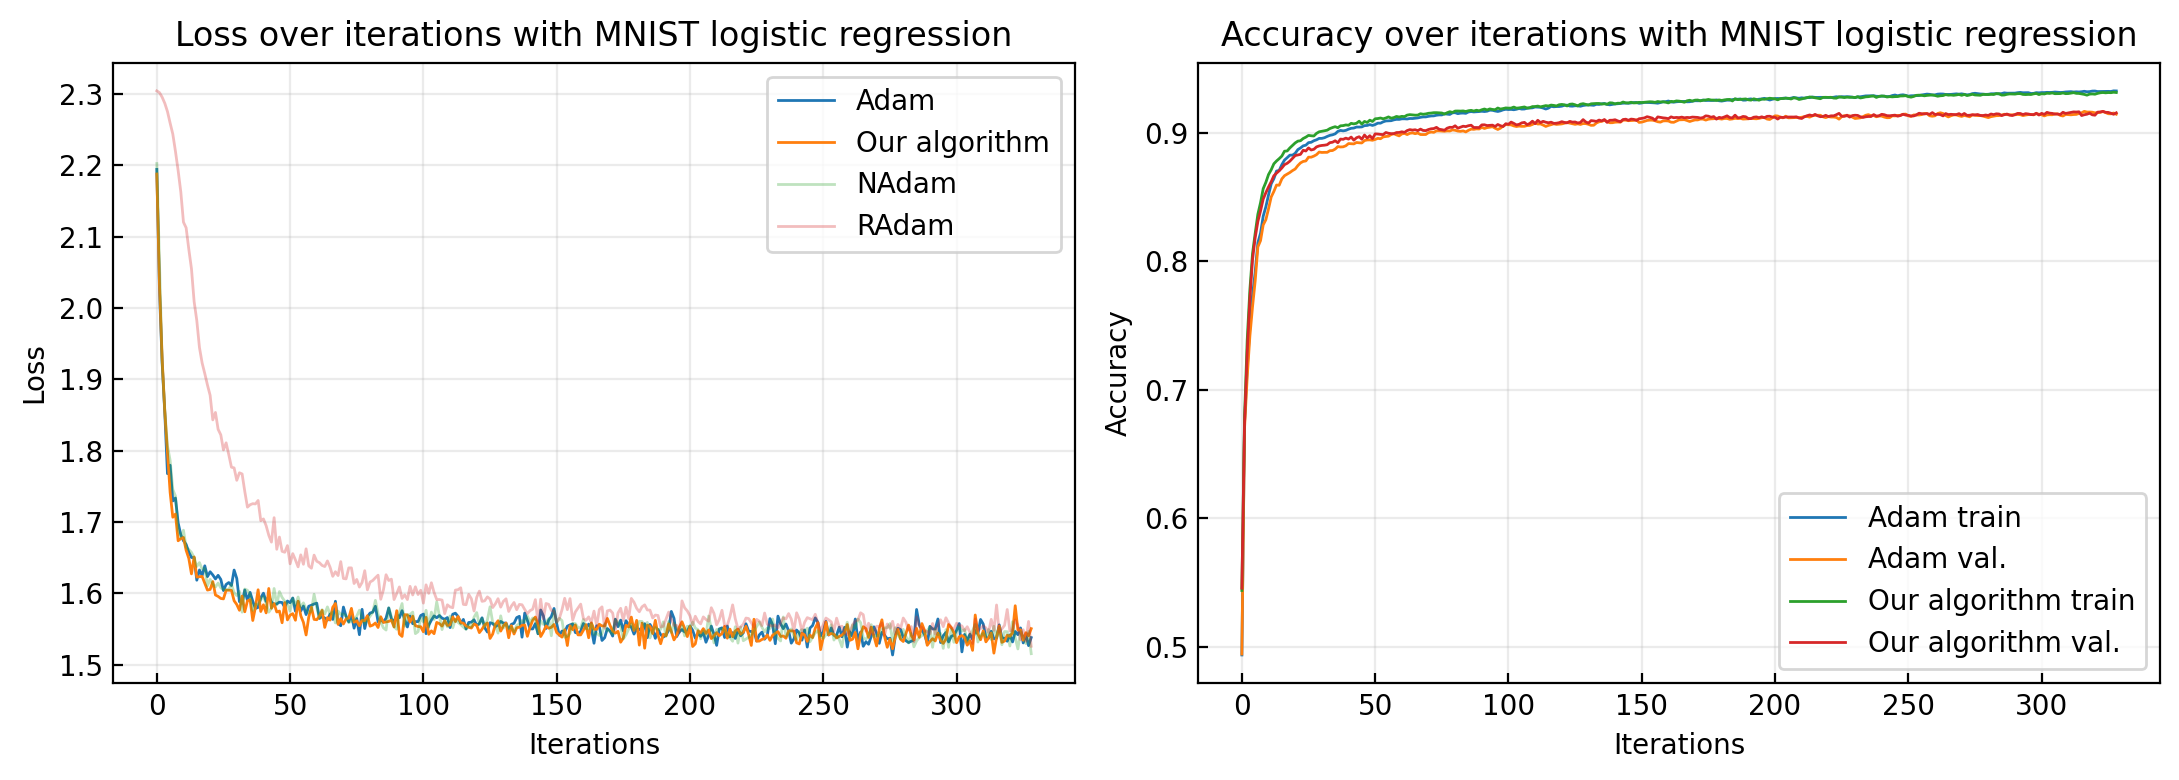

In [20]:
plt.figure(figsize=(11, 4), dpi=200)

plt.subplot(1, 2, 1)  # (rows, columns, plot_number)
plt.plot(np.arange(0, len(avg_train_loss_adam)), avg_train_loss_adam, label="Adam", lw=1)
plt.plot(np.arange(0, len(avg_train_loss_new)), avg_train_loss_new, label="Our algorithm", lw=1)
plt.plot(np.arange(0, len(avg_train_loss_n)), avg_train_loss_n, label="NAdam", lw=1, alpha=0.3)
plt.plot(np.arange(0, len(avg_train_loss_r)), avg_train_loss_r, label="RAdam", lw=1, alpha=0.3)
plt.title("Loss over iterations with MNIST logistic regression")
plt.tick_params(axis='both', direction='in')
plt.grid(True, alpha=0.25)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)  # (rows, columns, plot_number)
plt.plot(np.arange(0, len(avg_train_acc_adam)), avg_train_acc_adam, label="Adam train", lw=1)
plt.plot(np.arange(0, len(avg_train_acc_adam)), avg_val_acc_adam, label="Adam val.", lw=1)
plt.plot(np.arange(0, len(avg_train_acc_new)), avg_train_acc_new, label="Our algorithm train", lw=1)
plt.plot(np.arange(0, len(avg_train_acc_new)), avg_val_acc_new, label="Our algorithm val.", lw=1)
plt.tick_params(axis='both', direction='in')
plt.grid(True, alpha=0.25)
plt.title("Accuracy over iterations with MNIST logistic regression")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend()


# Show the plots
plt.tight_layout()  # Adjusts subplot parameters to give specified padding
plt.show()

In [23]:
model = LogisticRegression()
iters1, train_loss1, train_acc1, val_acc1 = train_model(model, train_data, val_data, optimizer_choice="NAdam", lambdas=(0.8, 0.8))
model = LogisticRegression()
iters2, train_loss2, train_acc2, val_acc2 = train_model(model, train_data, val_data, optimizer_choice="RAdam", lambdas=(0.8, 0.8))
model = LogisticRegression()
iters3, train_loss3, train_acc3, val_acc3 = train_model(model, train_data, val_data, optimizer_choice="New_Adam", lambdas=(0.8, 0.8))
model = LogisticRegression()
iters4, train_loss4, train_acc4, val_acc4 = train_model(model, train_data, val_data, optimizer_choice="Adam", lambdas=(0.8, 0.8))

Epoch [0/4] iter: 5    training loss: 2.1988556385040283   training acc: 0.47021427750587463   validation acc: 0.4625000059604645
Epoch [0/4] iter: 10    training loss: 2.06972599029541   training acc: 0.6592381000518799   validation acc: 0.6463333368301392
Epoch [0/4] iter: 15    training loss: 1.9595526456832886   training acc: 0.7050714492797852   validation acc: 0.6980000138282776
Epoch [0/4] iter: 20    training loss: 1.8889306783676147   training acc: 0.7451666593551636   validation acc: 0.7398333549499512
Epoch [0/4] iter: 25    training loss: 1.8132158517837524   training acc: 0.7668095231056213   validation acc: 0.7621666789054871
Epoch [0/4] iter: 30    training loss: 1.7669873237609863   training acc: 0.7717618942260742   validation acc: 0.7646666765213013
Epoch [0/4] iter: 35    training loss: 1.7768558263778687   training acc: 0.7864285707473755   validation acc: 0.7791666388511658
Epoch [0/4] iter: 40    training loss: 1.7455530166625977   training acc: 0.7975714206695557

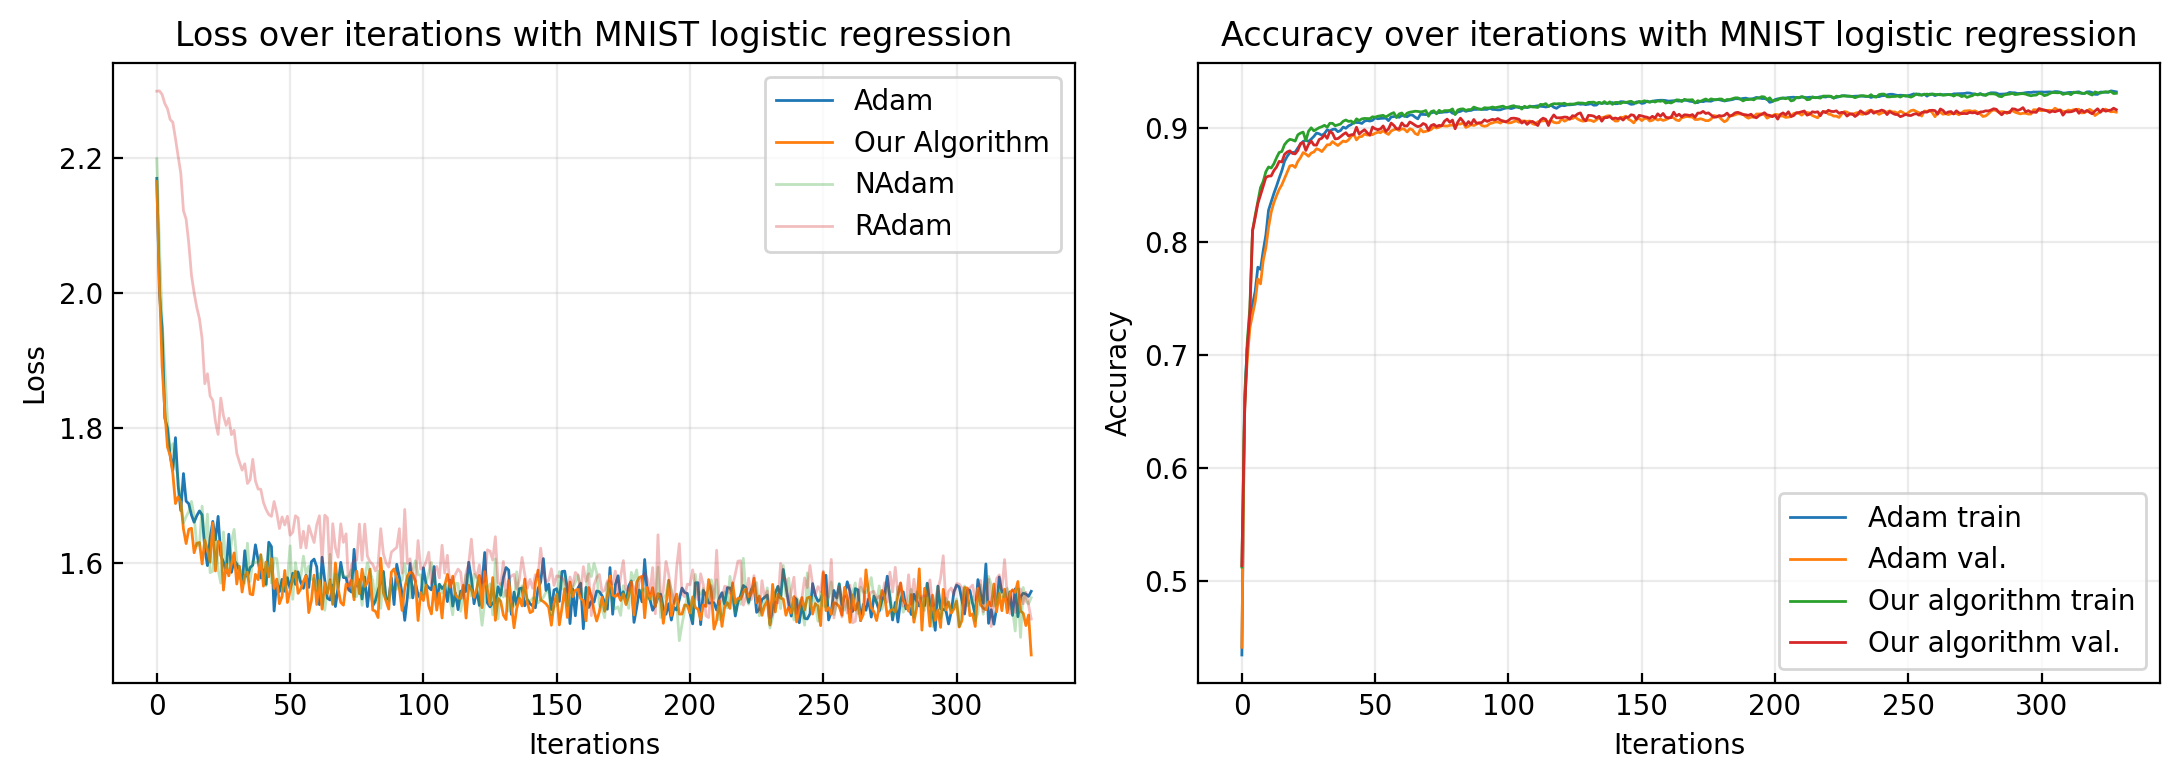

In [28]:
plt.figure(figsize=(11, 4), dpi=200)

plt.subplot(1, 2, 1)  # (rows, columns, plot_number)
plt.plot(np.arange(0, len(train_loss4)), train_loss4, label="Adam", lw=1)
plt.plot(np.arange(0, len(train_loss3)), train_loss3, label="Our Algorithm", lw=1)
plt.plot(np.arange(0, len(train_loss1)), train_loss1, label="NAdam", lw=1, alpha=0.3)
plt.plot(np.arange(0, len(train_loss2)), train_loss2, label="RAdam", lw=1, alpha=0.3)
plt.title("Loss over iterations with MNIST logistic regression")
plt.tick_params(axis='both', direction='in')
plt.grid(True, alpha=0.25)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)  # (rows, columns, plot_number)
plt.plot(np.arange(0, len(train_acc4)), train_acc4, label="Adam train", lw=1)
plt.plot(np.arange(0, len(val_acc4)), val_acc4, label="Adam val.", lw=1)
plt.plot(np.arange(0, len(train_acc3)), train_acc3, label="Our algorithm train", lw=1)
plt.plot(np.arange(0, len(val_acc3)), val_acc3, label="Our algorithm val.", lw=1)
plt.tick_params(axis='both', direction='in')
plt.grid(True, alpha=0.25)
plt.title("Accuracy over iterations with MNIST logistic regression")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend()


# Show the plots
plt.tight_layout()  # Adjusts subplot parameters to give specified padding
plt.show()

# Multi-layer Neural Network on MNIST

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784, 1000)
        self.fc2 = nn.Linear(1000, 1000)
        self.fc3 = nn.Linear(1000, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x

model33 = MLP()
iters33, train_loss33, train_acc33, val_acc33 = train_model(model33, train_data, val_data, optimizer_choice="AMSGrad")

model11 = MLP()
iters11, train_loss11, train_acc11, val_acc11 = train_model(model11, train_data, val_data, optimizer_choice="New_Adam", lambdas=(0.8,0.8))

model22 = MLP()
iters22, train_loss22, train_acc22, val_acc22 = train_model(model22, train_data, val_data, optimizer_choice="Adam")


Epoch [0/4] iter: 5    training loss: 2.10854434967041   training acc: 0.3939523696899414   validation acc: 0.3930000066757202
Epoch [0/4] iter: 10    training loss: 2.0337250232696533   training acc: 0.5257381200790405   validation acc: 0.5243333578109741
Epoch [0/4] iter: 15    training loss: 1.9171397686004639   training acc: 0.6078809499740601   validation acc: 0.6194999814033508
Epoch [0/4] iter: 20    training loss: 1.7839992046356201   training acc: 0.6725952625274658   validation acc: 0.6798333525657654
Epoch [0/4] iter: 25    training loss: 1.7380229234695435   training acc: 0.7131428718566895   validation acc: 0.7085000276565552
Epoch [0/4] iter: 30    training loss: 1.771672248840332   training acc: 0.7400714159011841   validation acc: 0.7381666898727417
Epoch [0/4] iter: 35    training loss: 1.664676547050476   training acc: 0.7318571209907532   validation acc: 0.7329999804496765
Epoch [0/4] iter: 40    training loss: 1.704750895500183   training acc: 0.7438571453094482   v

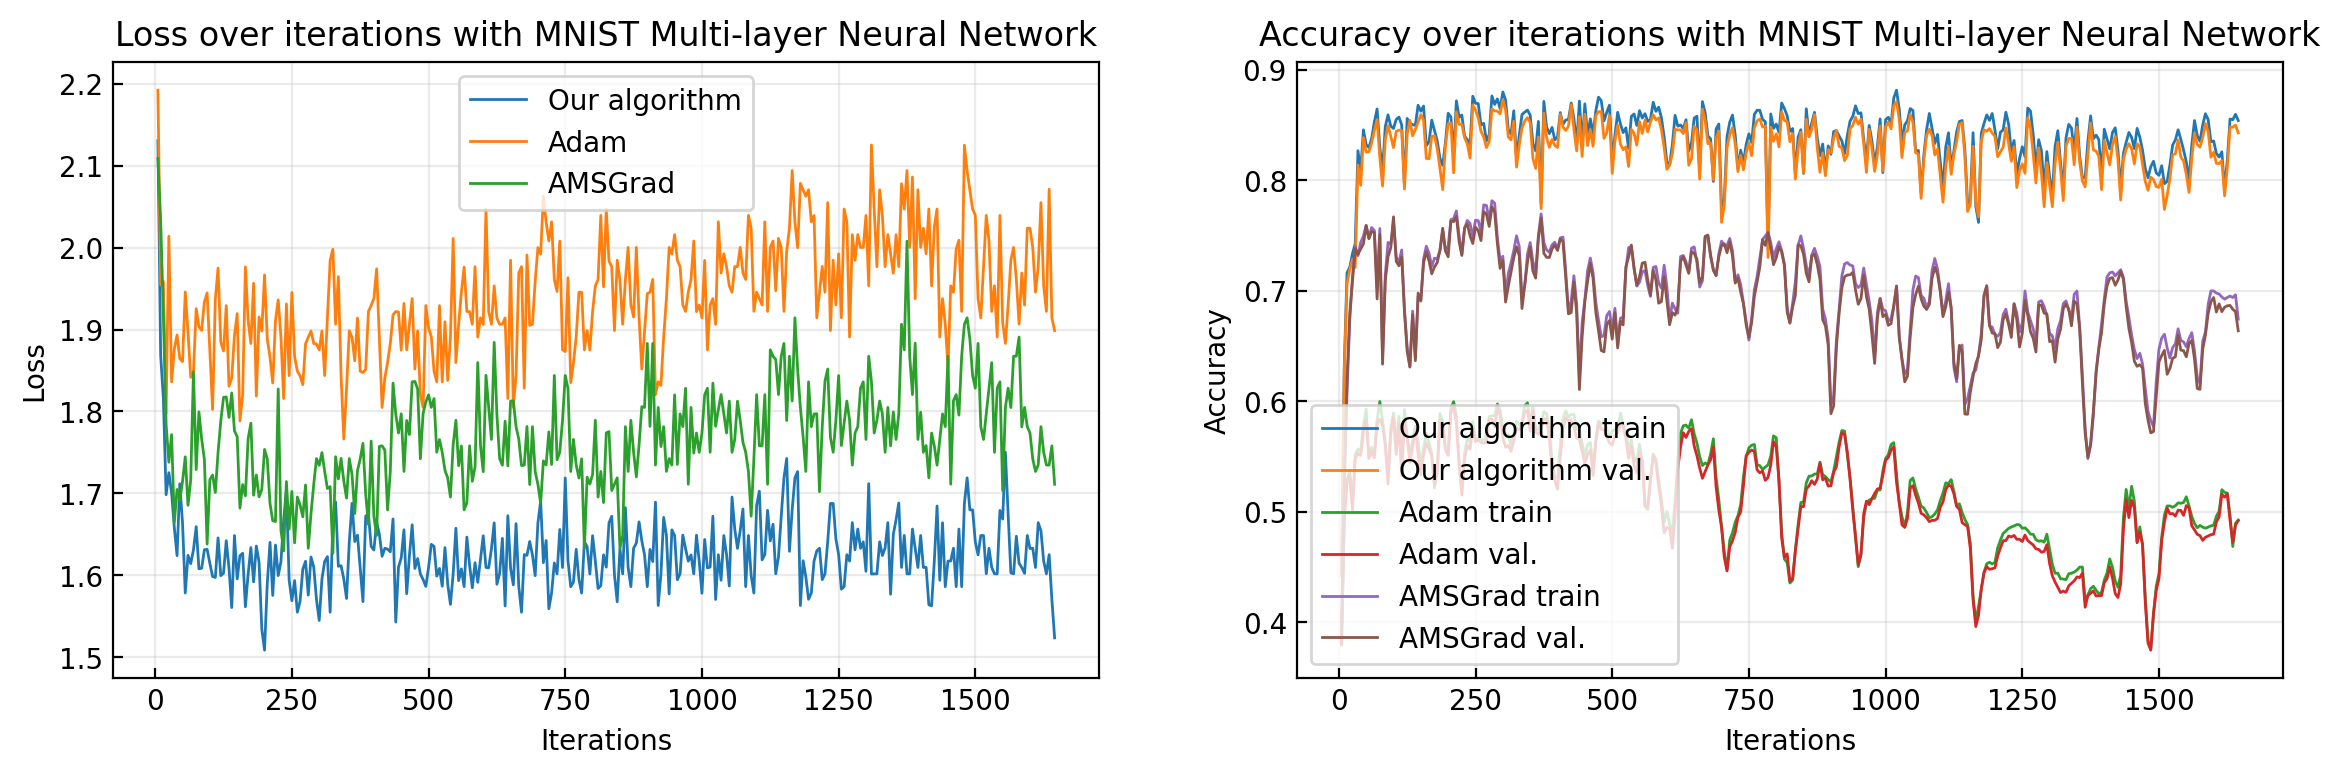

In [21]:
plt.figure(figsize=(14, 4), dpi=200)

plt.subplot(1, 2, 1)  # (rows, columns, plot_number)
plt.plot(iters11[:len(train_loss11)], train_loss11, label="Our algorithm", lw=1)
plt.plot(iters22[:len(train_loss22)], train_loss22, label="Adam", lw=1)
plt.plot(iters33[:len(train_loss33)], train_loss33, label="AMSGrad", lw=1)
# plt.plot(iters3[:len(train_loss3)], train_loss3, label="NAdam", lw=1, alpha=0.3)
# plt.plot(iters4[:len(train_loss4)], train_loss4, label="RAdam", lw=1, alpha=0.3)
plt.title("Loss over iterations with MNIST Multi-layer Neural Network")
plt.tick_params(axis='both', direction='in')
plt.grid(True, alpha=0.25)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)  # (rows, columns, plot_number)
plt.plot(iters11[:len(train_acc11)], train_acc11, label="Our algorithm train", lw=1)
plt.plot(iters11[:len(val_acc11)], val_acc11, label="Our algorithm val.", lw=1)
plt.plot(iters22[:len(train_acc22)], train_acc22, label="Adam train", lw=1)
plt.plot(iters22[:len(val_acc22)], val_acc22, label="Adam val.", lw=1)
plt.plot(iters33[:len(train_acc33)], train_acc33, label="AMSGrad train", lw=1)
plt.plot(iters33[:len(val_acc33)], val_acc33, label="AMSGrad val.", lw=1)
plt.tick_params(axis='both', direction='in')
plt.grid(True, alpha=0.25)
plt.title("Accuracy over iterations with MNIST Multi-layer Neural Network")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend()

# Grid Search


In [ ]:
gridsearch = {}
loss = 1000
for lam1 in [0.8, 0.82,0.84,0.86,0.88]:
    for lam2 in [0.8, 0.82,0.84,0.86,0.88]:


      modelname = f"lam1: {lam1}, lam2: {lam2}"
      print(f"========={modelname}")


      m = nn.Linear(784, 10)
      iters, train_loss, train_acc, val_acc = train_model(m, train_data, val_data, optimizer_choice="New_Adam", lambdas = (lam1,lam2))

      metrics = {
          "acc_train": train_acc[-1],
          "acc_val":  val_acc[-1],
          "train_loss": train_loss[-1]
      }
      gridsearch[modelname] = metrics
      print(f'Accuracy (train):{metrics["acc_train"]} (val):{metrics["acc_val"]} ')
      print(f'Loss (train):{metrics["train_loss"]}')
      if train_loss[-1] < loss:
        loss = train_loss[-1]
        best = (lam1,lam2)


print(best)